In [1]:
cd ~/Desktop/DeepLearningPilot/

/Users/jz-rolling/Desktop/DeepLearningPilot


In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from skimage import filters,morphology,measure
from scipy.stats import pearsonr
import seaborn as sns
from ncolor import label
from timeit import default_timer
import pickle as pk, glob, os
import momia2 as mo
from ncolor import label
import tifffile
from matplotlib import cm
import cv2

In [15]:
sample_dict = {}
for i in [12,13,14]:
    for j,k in enumerate(sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/pred_results/{}_*tracker.pk'.format(i)))):
        header = k.split('_tracker.pk')[0]
        phase = np.load(header+'_clips.npy')
        masks = np.load(header+'_omni_masks.npy')
        fitc = np.load(header+'_fitc.npy')
        merged_rp = pk.load(open(k,'rb'))
        sample_dict['{}_{}'.format(i,j)] = [phase,fitc,merged_rp,k,masks]

In [125]:
for roi_name,sample_data in sample_dict.items():
    phase,fitc,merged_rp,k,masks = sample_data

    outliers = []
    midline_profile_dict = {}
    for l in merged_rp['cell_lineage'].unique():
        cell = merged_rp[merged_rp['cell_lineage']==l].copy()
        midlines = []
        midline_profiles = []
        lengths = []
        areas = cell['area'].values
        p0 = None
        time_frames = []
        if len(areas)>5 and cell['$touching_edge'].max()==0:
            if np.abs(areas[:-1]-areas[1:]).max()<200:
                for t,mask,contour,aspect,x1,y1 in cell[['$time','$mask','$refined_contours','aspect_ratio','$opt-x1','$opt-y1']].values:
                    if aspect>0.5:
                        ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
                    else:
                        try:
                            ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=False)
                        except:
                            ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
                            outliers.append([mask,ml,contour[0]])
                    ml = ml+np.array([x1,y1])[np.newaxis,]
                    p1,p2 = ml[0],ml[-1]
                    if p0 is None:
                        p0 = p1
                    else:
                        d1 = mo.utils.linalg.distance_matrix(p0.reshape(1,-1),np.vstack([p1,p2])).ravel()
                        if np.argmin(d1)==0:
                            p0 = p1
                        else:
                            ml = np.flip(ml,axis=0)
                            p0 = p2                        
                    midlines.append(ml)
                    lengths.append(mo.utils.linalg.measure_length(ml))
                    midline_profiles.append(mo.utils.linalg.bilinear_interpolate_numpy(fitc[t],ml[:,0],ml[:,1]))
                lengths = np.array(lengths)
                midline_profile_dict[l] = [lengths,midline_profiles,cell['$time'].values]    

    for label,values in midline_profile_dict.items():            
        lengths,profiles,time = values
        max_l = lengths.max()*1.1
        max_n = 256
        interp_profiles = []
        for l,p in zip(lengths,profiles):
            half_n_pix = int(round(0.5*l*max_n/max_l))
            n_pix = half_n_pix*2
            pad = int((max_n-n_pix)/2)
            interp_n = np.linspace(0,1,n_pix)
            interp_x = np.linspace(0,1,len(p))
            interp_y = np.interp(interp_n,interp_x,p)
            interp_y = np.pad(interp_y,((pad,pad),))
            interp_profiles.append(interp_y)
        fig=plt.figure(figsize=(3,4))
        ax=fig.add_subplot()
        img_mat = np.array(interp_profiles)
        perc_98 = np.percentile(img_mat.ravel(),98)+100
        ax.imshow(np.array(interp_profiles),aspect='auto',vmin=920,vmax=np.max([2000,perc_98]),cmap='magma')
        ticks = np.array([0,int(round(0.25*len(lengths))),int(round(0.5*len(lengths))),int(round(0.75*len(lengths))),len(lengths)-1]);
        ax.set_yticks(ticks)
        ax.set_yticklabels(time[ticks],fontsize=14,fontname='Arial');
        ax.set_xticks([])
        ax.set_xlabel('normalized cell length',fontsize=14,fontname='Arial');
        ax.set_title('ROI {}, cell #{}'.format(roi_name,label),fontsize=14,fontname='Arial');
        plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/3_kymographs/{}_{}.png'.format(roi_name,label),dpi=160,bbox_inches='tight')
        plt.close()

In [ ]:
vmin=920,vmax=np.max([2000,perc_98])

In [16]:
for f in sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/3_kymographs/RIF_selected/*.png')):
    header = f.split('/')[-1].split('.png')[0]
    roi = '_'.join(header.split('_')[:2])
    cid = header.split('_')[-1]
    subf = '/Volumes/JZSSD_temp/20190709_NQTF/3_kymographs/RIF_selected/'
    new_fname = subf+'{}_{}_norm.csv'.format(roi,cid)
    phase=sample_dict[roi][0]
    fitc= sample_dict[roi][1]
    cell = sample_dict[roi][2][sample_dict[roi][2]['cell_lineage']==cid].copy()
    midlines=[]
    lengths = []
    midline_profiles = []
    p0 = None
    for t,mask,contour,aspect,x1,y1 in cell[['$time','$mask','$refined_contours','aspect_ratio','$opt-x1','$opt-y1']].values:
        if aspect>0.5:
            ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
        else:
            try:
                ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=False)
            except:
                ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
        ml = ml+np.array([x1,y1])[np.newaxis,]
        p1,p2 = ml[0],ml[-1]
        if p0 is None:
            p0 = p1
        else:
            d1 = mo.utils.linalg.distance_matrix(p0.reshape(1,-1),np.vstack([p1,p2])).ravel()
            if np.argmin(d1)==0:
                p0 = p1
            else:
                ml = np.flip(ml,axis=0)
                p0 = p2                        
        midlines.append(ml)
        lengths.append(mo.utils.linalg.measure_length(ml))
        midline_profiles.append(mo.utils.linalg.bilinear_interpolate_numpy(fitc[t],ml[:,0],ml[:,1]))
        
    lengths = np.array(lengths)
    max_l = lengths.max()*1.1
    max_n = 256
    interp_profiles = []
    interp_lengths = []
    df = pd.DataFrame()
    
    vmin=920
    vmax=max(np.percentile(np.concatenate(midline_profiles),98),2000)
    for i,(l,p) in enumerate(zip(lengths,midline_profiles)):
        t=cell['$time'].values[i]
        half_n_pix = int(round(0.5*l*max_n/max_l))
        n_pix = half_n_pix*2
        pad = int((max_n-n_pix)/2)
        interp_l = np.zeros(max_n)+np.nan
        interp_y = np.zeros(max_n)+np.nan
        interp_n = np.linspace(0,1,n_pix)
        interp_x = np.linspace(0,1,len(p))
        interp_l[:n_pix] = np.interp(interp_n,[0,1],[0,l*0.065])
        interp_y[:n_pix] = np.interp(interp_n,interp_x,normalization(p,vmin=vmin,vmax=vmax))
        df['Time point: {}, cell axis coordinate [µm]'.format(t)]=interp_l
        df['Time point: {}, green fluorescence'.format(t)] = interp_y
    df.to_csv(new_fname,na_rep='')

In [11]:
def normalization(data,vmin,vmax):
    normd = (data-vmin)/(vmax-vmin)
    normd[normd>1]=1
    normd[normd<0]=0
    return normd

array([1135.27328655, 1113.27066127, 1125.75467147, ..., 1520.12637091,
       1703.49443536, 1920.37288347])

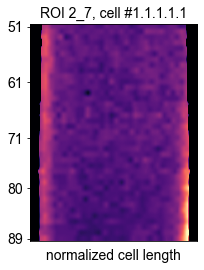

In [113]:
for roi_name,sample_data in sample_dict.items():
    phase,fitc,merged_rp,k,masks = sample_data

    outliers = []
    midline_profile_dict = {}
    for l in merged_rp['cell_lineage'].unique():
        cell = merged_rp[merged_rp['cell_lineage']==l].copy()
        midlines = []
        midline_profiles = []
        lengths = []
        areas = cell['area'].values
        p0 = None
        time_frames = []
        if len(areas)>5 and cell['$touching_edge'].max()==0:
            if np.abs(areas[:-1]-areas[1:]).max()<200:
                for t,mask,contour,aspect,x1,y1 in cell[['$time','$mask','$refined_contours','aspect_ratio','$opt-x1','$opt-y1']].values:
                    if aspect>0.5:
                        ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
                    else:
                        try:
                            ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=False)
                        except:
                            ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
                            outliers.append([mask,ml,contour[0]])
                    ml = ml+np.array([x1,y1])[np.newaxis,]
                    p1,p2 = ml[0],ml[-1]
                    if p0 is None:
                        p0 = p1
                    else:
                        d1 = mo.utils.linalg.distance_matrix(p0.reshape(1,-1),np.vstack([p1,p2])).ravel()
                        if np.argmin(d1)==0:
                            p0 = p1
                        else:
                            ml = np.flip(ml,axis=0)
                            p0 = p2                        
                    midlines.append(ml)
                    lengths.append(mo.utils.linalg.measure_length(ml))
                    midline_profiles.append(mo.utils.linalg.bilinear_interpolate_numpy(fitc[t],ml[:,0],ml[:,1]))
                lengths = np.array(lengths)
                midline_profile_dict[l] = [lengths,midline_profiles,cell['$time'].values]    

    for label,values in midline_profile_dict.items():            
        lengths,profiles,time = values
        max_l = lengths.max()*1.1
        max_n = 256
        interp_profiles = []
        for l,p in zip(lengths,profiles):
            half_n_pix = int(round(0.5*l*max_n/max_l))
            n_pix = half_n_pix*2
            pad = int((max_n-n_pix)/2)
            interp_n = np.linspace(0,1,n_pix)
            interp_x = np.linspace(0,1,len(p))
            interp_y = np.interp(interp_n,interp_x,p)
            interp_y = np.pad(interp_y,((pad,pad),))
            interp_profiles.append(interp_y)
        fig=plt.figure(figsize=(3,4))
        ax=fig.add_subplot()
        img_mat = np.array(interp_profiles)
        perc_98 = np.percentile(img_mat.ravel(),98)+100
        ax.imshow(np.array(interp_profiles),aspect='auto',vmin=920,vmax=np.max([2000,perc_98]),cmap='magma')
        ticks = np.array([0,int(round(0.25*len(lengths))),int(round(0.5*len(lengths))),int(round(0.75*len(lengths))),len(lengths)-1]);
        ax.set_yticks(ticks)
        ax.set_yticklabels(time[ticks],fontsize=14,fontname='Arial');
        ax.set_xticks([])
        ax.set_xlabel('normalized cell length',fontsize=14,fontname='Arial');
        ax.set_title('ROI {}, cell #{}'.format(roi_name,label),fontsize=14,fontname='Arial');
        plt.savefig('/Volumes/JZSSD_temp/20190709_NQTF/3_kymographs/{}_{}.png'.format(roi_name,label),dpi=160,bbox_inches='tight')
        plt.close()

In [4]:
sample_dict = {}
for i in range(2,3):
    for j,k in enumerate(sorted(glob.glob('/Volumes/JZSSD_temp/20190709_NQTF/pred_results/{}_*tracker.pk'.format(i)))):
        header = k.split('_tracker.pk')[0]
        phase = np.load(header+'_clips.npy')
        masks = np.load(header+'_omni_masks.npy')
        fitc = np.load(header+'_fitc.npy')
        merged_rp = pk.load(open(k,'rb'))
        sample_dict['{}_{}'.format(i,j)] = [phase,fitc,merged_rp,k,masks]

In [287]:
k = '2_2'
merged_rp = sample_dict[k][2]
phase = sample_dict[k][0]
fitc = sample_dict[k][1]

unique_cells = merged_rp['cell_lineage'].unique()
count_dict = {}
for x in unique_cells:
    rid = x.split('.')[0]
    if not rid in count_dict:
        count_dict[rid]=1
    else:
        count_dict[rid]+=1
#filter count
color_count = 0
color_dict = {}
for i,(ac,count) in enumerate(count_dict.items()):
    if count>2:
        color_dict[ac]=cm.get_cmap('tab20')(color_count)
        color_count+=1

In [288]:
color_dict

{'4': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 '5': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0),
 '7': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 '9': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0)}

In [290]:
tree = []
for l in unique_cells:
    if l =='4' or l.startswith('4.'):
        cell = merged_rp[merged_rp['cell_lineage']==l].copy()
        midlines = []
        for mask,contour,aspect,x1,y1 in cell[['$mask','$refined_contours','aspect_ratio','$opt-x1','$opt-y1']].values:
            if aspect<0.5:
                ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=True)
            else:
                ml=mo.utils.skeleton.mask2midline(mask,contour[0],ellipse_fast=False)
            midlines.append(ml)
        cell['$midlines'] = midlines
        tree.append(cell)
tree = pd.concat(tree)

In [291]:
stack = []
last_frame_poles = []
for t in np.sort(tree['$time'].unique()):
    frame = tree[tree['$time']==t].copy()
    if len(frame)==1:
        x1,y1,midline = frame[['$opt-x1','$opt-y1','$midlines']].values[0]
        midline = midline+np.array([x1,y1])[np.newaxis,:]
        if len(last_frame_poles)==0:
            last_frame_poles = np.array([midline[0],midline[-1]])
            stack.append([midline])
        else:
            current_frame_poles = np.array([midline[0],midline[-1]])
            mat = mo.utils.linalg.distance_matrix(last_frame_poles,current_frame_poles)
            if np.argmin(mat[0])==0:
                stack.append([midline])
                last_frame_poles = np.array([midline[0],midline[-1]])
            else:
                stack.append([np.flip(midline,axis=0)])
                last_frame_poles = np.array([midline[-1],midline[0]])
    else:
        midline_list = []
        current_frame_poles = []
        for x1,y1,midline in frame[['$opt-x1','$opt-y1','$midlines']].values:
            midline_list.append(midline+np.array([x1,y1])[np.newaxis,:])
            current_frame_poles.append(midline_list[-1][0])
            current_frame_poles.append(midline_list[-1][-1])
        current_frame_poles=np.array(current_frame_poles)
        inter_mat = mo.utils.linalg.distance_matrix(last_frame_poles,current_frame_poles)
        intra_mat = mo.utils.linalg.distance_matrix(current_frame_poles,current_frame_poles)
        intra_mat[np.diag_indices_from(intra_mat)]=np.inf
        
        re_ordered_poles = []
        re_ordered_midlines = []
        
        start_id = np.argmin(inter_mat[0])
        counter = 0
        while True:
            if counter == len(midline_list):
                break
            end_id = _get_other_pole(start_id)
            cell_id = int(start_id/2)
            flip = start_id%2
            if flip:
                re_ordered_midlines.append(np.flip(midline_list[cell_id],axis=0))
                re_ordered_poles += [midline_list[cell_id][-1],midline_list[cell_id][0]]
            else:
                re_ordered_midlines.append(midline_list[cell_id])
                re_ordered_poles += [midline_list[cell_id][0],midline_list[cell_id][-1]]
            counter+=1
            start_id = np.argmin(intra_mat[end_id])
        stack.append(re_ordered_midlines)
        last_frame_poles = np.array(re_ordered_poles)
        
def _get_other_pole(idx):
    if idx%2 == 0:
        return idx+1
    else:
        return idx-1

In [292]:
len(intensity_stack[-1])

540

In [296]:
intensity_stack = []
lengths = []
for i,line in zip(np.sort(tree['$time'].unique()),stack):
    loc = [len(x) for x in line]
    interp_stack=[]
    for x in line:
        l = int(mo.utils.linalg.measure_length(x)*2)
        v = mo.utils.linalg.bilinear_interpolate_numpy(fitc[i],x[:,0],x[:,1])
        interp_v = np.interp(np.linspace(0,1,l),np.linspace(0,1,len(v)),v)
        interp_stack.append(interp_v)
    intensities = np.concatenate(interp_stack)
    intensity_stack.append(intensities)
    
padded_pack = []
for x in intensity_stack:
    padded_pack.append(np.pad(x,((0,2000-len(x)),)))

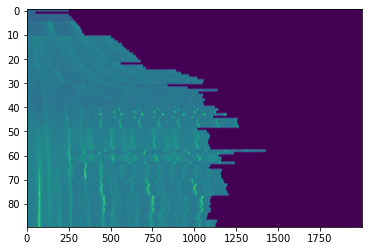

In [297]:
plt.imshow(np.array(padded_pack),aspect='auto')

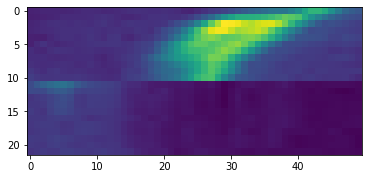

In [316]:
xx = lineage_tree['4.1.2.2'][1]
interp_stack = []
for x in xx:
    l = int(mo.utils.linalg.measure_length(x)*2)
    v = mo.utils.linalg.bilinear_interpolate_numpy(fitc[i],x[:,0],x[:,1])
    interp_v = np.interp(np.linspace(0,1,50),np.linspace(0,1,len(v)),v)
    interp_stack.append(interp_v)
plt.imshow(np.array(interp_stack))

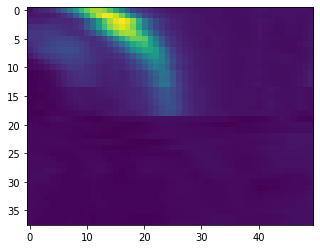

In [308]:
mother = '4'
lineage_tree = {}
pole_tree = {}
for l in tree['cell_lineage'].unique():
    if l =='4' or l.startswith('4.'):
        lineage_list = []
        pole_list = [] 
        p0 = None
        cell = tree[tree['cell_lineage']==l].copy()
        for x1,y1,ml,mask in cell[['$opt-x1','$opt-y1','$midlines','$mask']].values:    
            ml_shifted = ml+np.array([x1,y1])[np.newaxis,:]
            p1,p2 = ml_shifted[0],ml_shifted[-1]
            if p0 is None:
                p0 = p1
                lineage_list.append(ml_shifted)
            else:
                d1 = mo.utils.linalg.distance_matrix(p0.reshape(1,-1),np.vstack([p1,p2])).ravel()
                if np.argmin(d1)==0:
                    lineage_list.append(ml_shifted)
                    p0 = p1
                    pole_list.append([p1,p2])
                else:
                    lineage_list.append(np.flip(ml_shifted))
                    p0 = p2
                    pole_list.append([p2,p1])
        lineage_tree[l] = [cell['$time'].values,lineage_list,np.array(pole_list),]
        

In [ ]:
p0 = None
for t in tree['$time'].unique():
    frame = tree[tree['$time']==t].copy()
    for x1,y1,ml,mask in cell[['$opt-x1','$opt-y1','$midlines','$mask']].values:    
        ml_shifted = ml+np.array([x1,y1])[np.newaxis,:]
        if p0 is None:
            p0 = p1

In [81]:
tree.loc[cell['mother(s)'].values[0][0]]['cell_lineage']

'4.1.1'

In [107]:

lineage_order = {}

anc = ['4']
visited = []
while True:
    if len(visited) == len(lineage_tree):
        break
    new_anc = []
    for c in anc:
        if c in lineage_tree:
            visited.append(c)
            new_anc+=lineage_tree_update(lineage_tree,c)
    anc = new_anc
        
def lineage_tree_update(lineage_tree,lineage_order,
                        mother):
    c = mother
    d1,d2 = c+'.1',c+'.2'
    p01,p02 = lineage_tree[c][-1][-1][0],lineage_tree[c][-1][-1][1]
    if d1 in lineage_tree and d2 in lineage_tree:
        p11,p12 = lineage_tree[d1][-1][0][0],lineage_tree[d1][-1][0][1]
        p21,p22 = lineage_tree[d2][-1][0][0],lineage_tree[d2][-1][0][1]
        mother_pole_stack = np.array([p01,p02])
        daughter_pole_stack = np.array([p11,p12,p21,p22])
        mat = mo.utils.linalg.distance_matrix(mother_pole_stack,daughter_pole_stack)
        p1_match = np.argmin(mat,axis=1)[0]
        p2_match = np.argmin(mat,axis=1)[1]
        if p1_match in [0,1]:
            lineage_order[c] = [d1,d2]
            if p1_match==1:
                flipped_d1 = [np.flip(x,axis=0) for x in lineage_tree[d1][1]]
                lineage_tree[d1][1] = flipped_d1
                print('hi')
            if p2_match==2:
                flipped_d2 = [np.flip(x,axis=0) for x in lineage_tree[d2][1]]
                lineage_tree[d2][1] = flipped_d1
                print('hi')
        else:
            lineage_order[c] = [d2,d1]
            if p1_match==3:
                flipped_d2 = [np.flip(x,axis=0) for x in lineage_tree[d2][1]]
                lineage_tree[d2][1] = flipped_d1  
                print('hi')
            if p2_match==0:
                flipped_d1 = [np.flip(x,axis=0) for x in lineage_tree[d1][1]]
                lineage_tree[d1][1] = flipped_d1
                print('hi')
        return [d1,d2]
    elif d1 in lineage_tree:
        p11,p12 = lineage_tree[d1][-1][0][0],lineage_tree[d1][-1][0][1]
        daughter_pole_stack = np.array([p11,p12])
        mat = mo.utils.linalg.distance_matrix(mother_pole_stack,daughter_pole_stack)
        p1_match = np.argmin(mat,axis=1)[0]
        p2_match = np.argmin(mat,axis=1)[1]
        if p1_match == 0

KeyError: '4.2.1'

In [105]:
lineage_tree.keys()

dict_keys(['4', '4.1', '4.2', '4.1.1', '4.1.2', '4.1.1.1', '4.1.1.2'])

In [89]:
mother_pole_stack

array([[ 65.51530007, 134.08499775],
       [133.22640011, 119.59537275]])

In [90]:
daughter_pole_stack

array([[ 57.5323514 , 132.79587865],
       [100.64332674, 127.90856425],
       [ 99.96967972, 123.63356451],
       [133.59991961, 122.23534265]])

In [108]:
lineage_tree

{'4': [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20]),
  [array([[115.4188379 , 123.81033861],
          [117.63491877, 123.16039895],
          [119.87106642, 122.54045134],
          [122.10699731, 121.91372765],
          [124.32242789, 121.24345974],
          [126.49707462, 120.49287947],
          [128.61065396, 119.62521871],
          [130.64288237, 118.60370929],
          [132.5734763 , 117.3915831 ],
          [134.3821522 , 115.95207199],
          [136.04862655, 114.24840781]]),
   array([[111.36048109, 124.88327931],
          [113.16193088, 124.39820764],
          [114.949515  , 123.87232554],
          [116.72506865, 123.31099705],
          [118.49042706, 122.71958617],
          [120.24742546, 122.10345694],
          [121.99789906, 121.46797336],
          [123.7436831 , 120.81849947],
          [125.48661278, 120.16039928],
          [127.22852335, 119.49903681],
          [128.97125   , 118.83977608],
         